In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os

In [2]:
os.chdir('C:\\Users\\paari\\OneDrive\\Desktop\\finding-lanes')
image=mpimg.imread('solidWhiteRight.jpg')

In [3]:
#making a copy of the image
ysize=image.shape[0]
xsize=image.shape[1]
color_select=np.copy(image)
line_image=np.copy(image)

Lane lines are usually white in color so we have to modify the RGB values for the color selection criteria to (255,255,255) which are ideal values.
We could lessen the threshold so that even if the intensity is less, we could detect it.

In [4]:
red=200
blue=200
green=200
rgb_threshold=[red,green,blue]
#identify the pixels that are below the pixels
thresholds=(image[:,:,0]<rgb_threshold[0])|(image[:,:,1]<rgb_threshold[1])|image[:,:,2]<rgb_threshold[2]
color_select[thresholds]=[0,0,0]
#those pixels are set to black

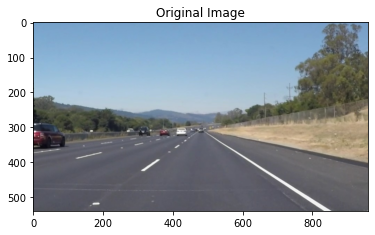

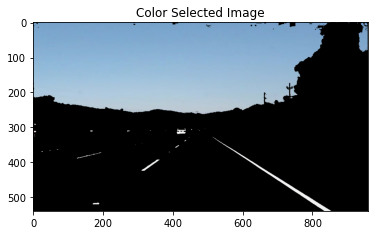

In [5]:
plt.imshow(image)
plt.title("Original Image")
plt.show()
plt.imshow(color_select)
plt.title("Color Selected Image")
plt.show()

Note that the lane lines are visible in the above color selected image

To pick out the area of interest, we have to create a polygonal mask (in this case a triangular mask).

In [6]:
#Note that to set the coordinates of the triangle,
# the origin should be considered to be at the
# upper left corner
left_bottom=[100,500]
right_bottom=[900,500]
apex=[500,300]

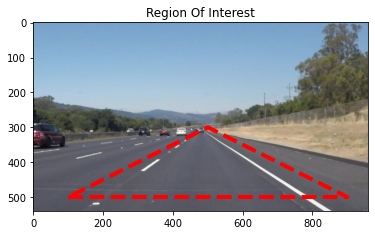

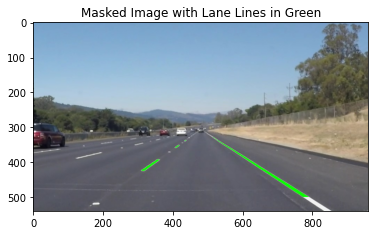

In [7]:
#linear fit is done to each sides of the triangle
#every straight line satisfies the slope intercept
# form y=mx+c
#np.polyfit returns the coefficients [m,c]

fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Mask pixels below the threshold
color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                    (image[:,:,1] < rgb_threshold[1]) | \
                    (image[:,:,2] < rgb_threshold[2])

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))
                    
# Mask color and region selection
color_select[color_thresholds | ~region_thresholds] = [0, 0, 0]
# Color pixels red where both color and region selections met
line_image[~color_thresholds & region_thresholds] = [9, 255, 0]
# Display the image and show region and color selections
plt.imshow(image)
x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
plt.plot(x, y, 'r--', lw=4)
plt.title("Region Of Interest")
plt.show()
plt.imshow(line_image)
plt.title("Masked Image with Lane Lines in Green")
plt.show()

#### Gaussian smoothing and Canny edge detection
Image is stored as a collection of discrete pixels with intensity values of 0 to 255.
To smoothen an image, we have to set each pixel value as average of the intensity. This reduces noise in the image.

Edges are where there's a drastic change in intensity. By computing the derivative, we measure or we compute the gradient in different directions i.e. change in intensity in a series of pixels. This is done by canny function. So, it
traces the strongest gradient as white pixels
i.e high change in intensity of colors are shown as white whereas small changes remain black.
    

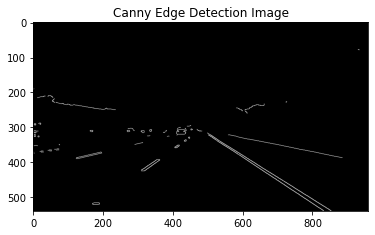

In [8]:
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
# Define a kernel size for Gaussian smoothing / blurring
kernel_size = 5 # Must be an odd number (3, 5, 7...)
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Define our parameters for Canny and run it
low_threshold = 180
high_threshold = 240
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Display the image
plt.imshow(edges, cmap='Greys_r')
plt.title("Canny Edge Detection Image")
plt.show()

#### Hough Transform and detecting lane lines

In Hough space, a line plotted in x,y coordinates which can be represented as y=mx+c is plotted in terms of axes m vs c which is the Hough transform.

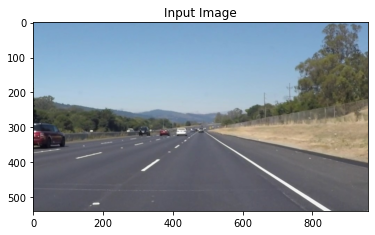

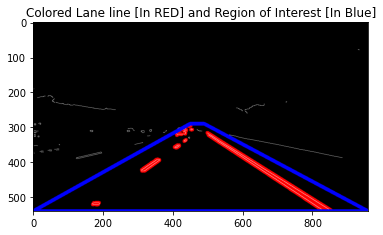

In [9]:

# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 2     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 4 #minimum number of pixels making up a line
max_line_gap = 5    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
lines_edges = cv2.polylines(lines_edges,vertices, True, (0,0,255), 10)
plt.imshow(image)
plt.title("Input Image")
plt.show()
plt.imshow(lines_edges)
plt.title("Colored Lane line [In RED] and Region of Interest [In Blue]")
plt.show()

### Pipelining the model

In [10]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
     Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
   for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def slope_lines(image,lines):
    
    img = image.copy()
    poly_vertices = []
    order = [0,1,3,2]

    left_lines = [] # Like /
    right_lines = [] # Like \
    for line in lines:
        for x1,y1,x2,y2 in line:

            if x1 == x2:
                pass #Vertical Lines
            else:
                m = (y2 - y1) / (x2 - x1)
                c = y1 - m * x1

            if m < 0:
                left_lines.append((m,c))
            elif m >= 0:
                right_lines.append((m,c))
    left_line = np.mean(left_lines, axis=0)
    right_line = np.mean(right_lines, axis=0)

    #print(left_line, right_line)

    for slope, intercept in [left_line, right_line]:

        #getting complete height of image in y1
        rows, cols = image.shape[:2]
        y1= int(rows) #image.shape[0]

        #taking y2 upto 60% of actual height or 60% of y1
        y2= int(rows*0.6) #int(0.6*y1)
        
        #we know that equation of line is y=mx +c so we can write it x=(y-c)/m
        x1=int((y1-intercept)/slope)
        x2=int((y2-intercept)/slope)
        poly_vertices.append((x1, y1))
        poly_vertices.append((x2, y2))
        draw_lines(img, np.array([[[x1,y1,x2,y2]]]))
    
    poly_vertices = [poly_vertices[i] for i in order]
    cv2.fillPoly(img, pts = np.array([poly_vertices],'int32'), color = (0,255,0))
    return cv2.addWeighted(image,0.7,img,0.4,0.)
    
    #cv2.polylines(img,np.array([poly_vertices],'int32'), True, (0,0,255), 10)
    #print(poly_vertices)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    line_img = slope_lines(line_img,lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.1, β=1., γ=0.):
    lines_edges = cv2.addWeighted(initial_img, α, img, β, γ)
    #lines_edges = cv2.polylines(lines_edges,get_vertices(img), True, (0,0,255), 10)
    return lines_edges
def get_vertices(image):
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.15, rows]
    top_left     = [cols*0.45, rows*0.6]
    bottom_right = [cols*0.95, rows]
    top_right    = [cols*0.55, rows*0.6] 
    
    ver = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return ver

In [11]:
def lane_finding_pipeline(image):
    
    #Grayscale
    gray_img = grayscale(image)
    #Gaussian Smoothing
    smoothed_img = gaussian_blur(img = gray_img, kernel_size = 5)
    #Canny Edge Detection
    canny_img = canny(img = smoothed_img, low_threshold = 180, high_threshold = 240)
    #Masked Image Within a Polygon
    masked_img = region_of_interest(img = canny_img, vertices = get_vertices(image))
    #Hough Transform Lines
    houghed_lines = hough_lines(img = masked_img, rho = 1, theta = np.pi/180, threshold = 20, min_line_len = 20, max_line_gap = 180)
    #Draw lines on edges
    output = weighted_img(img = houghed_lines, initial_img = image, α=0.8, β=1., γ=0.)
    
    return output

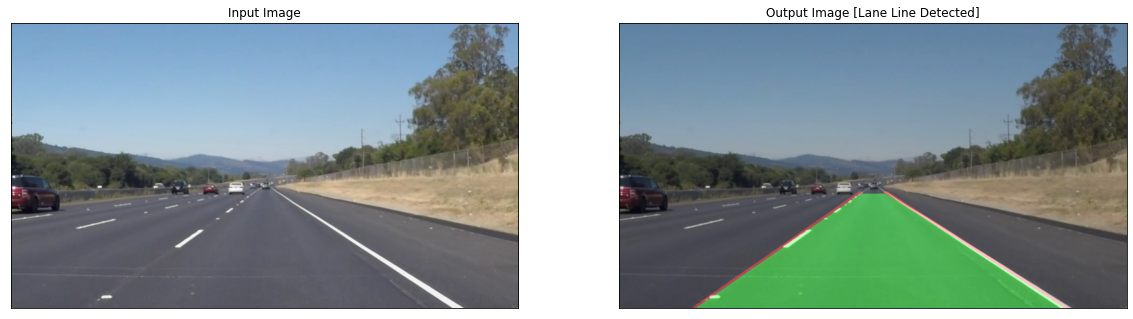

In [12]:
fig = plt.figure(figsize=(20, 10))
image = mpimg.imread('solidWhiteRight.jpg')
ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
plt.imshow(image)
ax.set_title("Input Image")
ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])
plt.imshow(lane_finding_pipeline(image))
ax.set_title("Output Image [Lane Line Detected]")
plt.show()

In [13]:
!pip install moviepy


In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
white_output = './solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/jaipurHighway.mp4").subclip(50,60)
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(lane_finding_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   1%|▉                                                                    | 3/221 [00:00<00:09, 23.23it/s, now=None]

Moviepy - Building video ./solidWhiteRight.mp4.
Moviepy - Writing video ./solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready ./solidWhiteRight.mp4
Wall time: 3.19 s


In [16]:
HTML("""
<video width="500" height="500" controls>
  <source src="{0}">
</video>
""".format(white_output))